Train shape: (12654, 25)
           trip_id       country age_group             travel_companions  \
0  tour_idftaa27vp        FRANCE     45-64      With Spouse and Children   
1  tour_iduck75m57         KENYA     45-64                         Alone   
2  tour_id8y3w40h8  SOUTH AFRICA     25-44  With Other Friends/Relatives   
3  tour_idkoh8mkgr         ITALY     25-44                   With Spouse   
4  tour_idkmsfa00a         ITALY     25-44                   With Spouse   

   num_females  num_males       main_activity            visit_purpose  \
0          1.0        2.0       Beach Tourism     Leisure and Holidays   
1          1.0        0.0  Conference Tourism  Meetings and Conference   
2          2.0        0.0    Cultural Tourism  Meetings and Conference   
3          1.0        1.0     Widlife Tourism     Leisure and Holidays   
4          1.0        1.0       Beach Tourism     Leisure and Holidays   

  is_first_visit  mainland_stay_nights  ...  food_included  \
0          

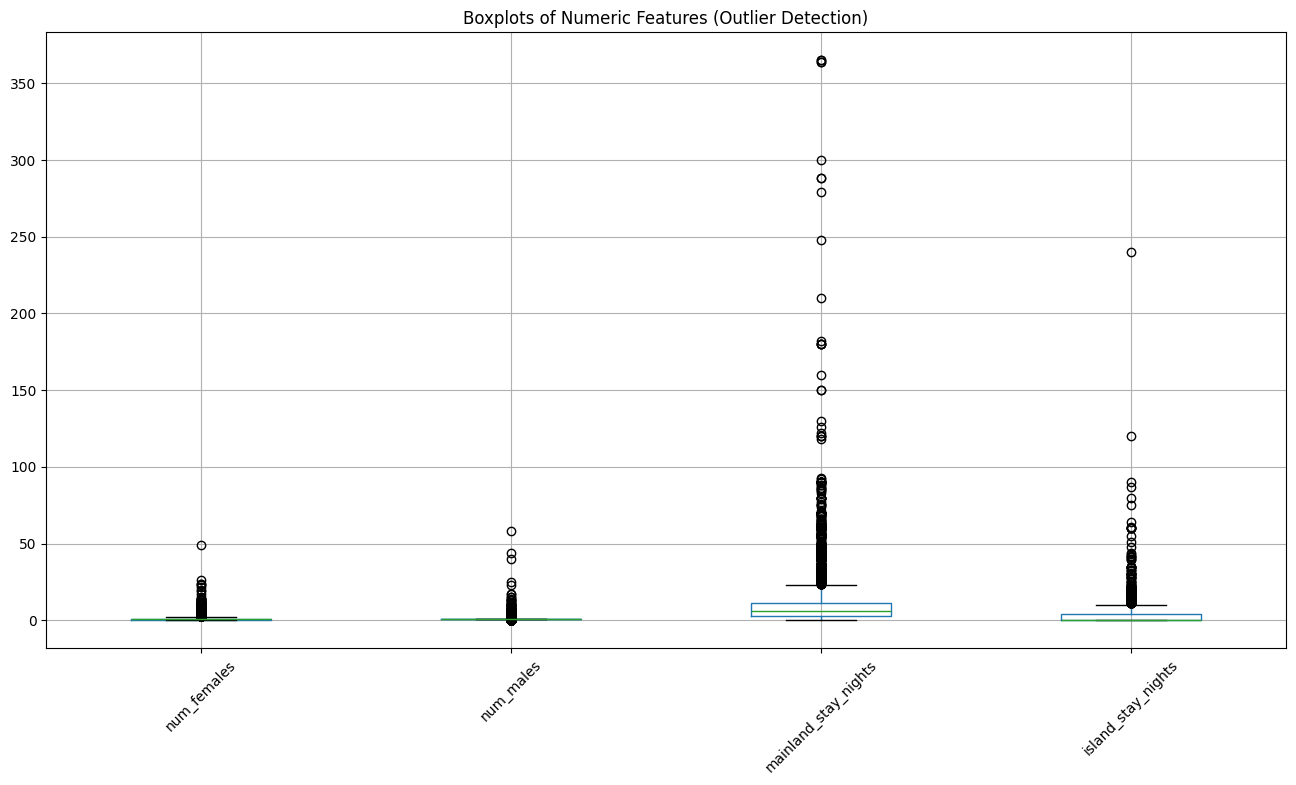

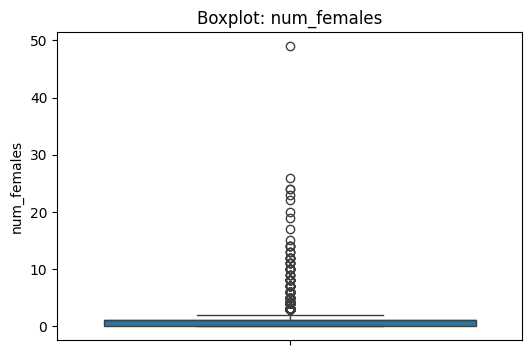

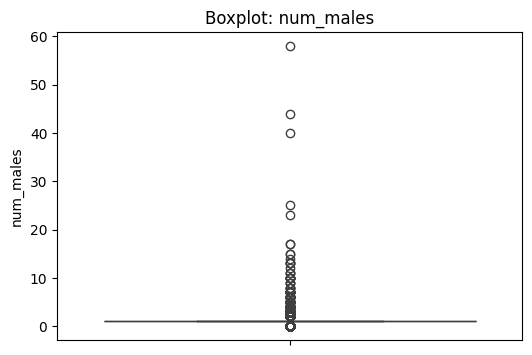

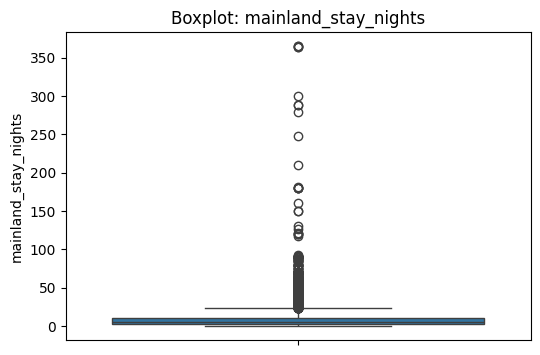

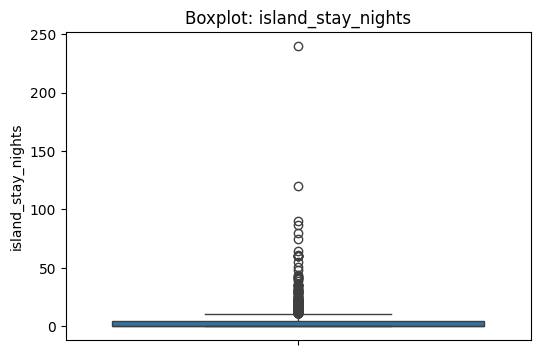

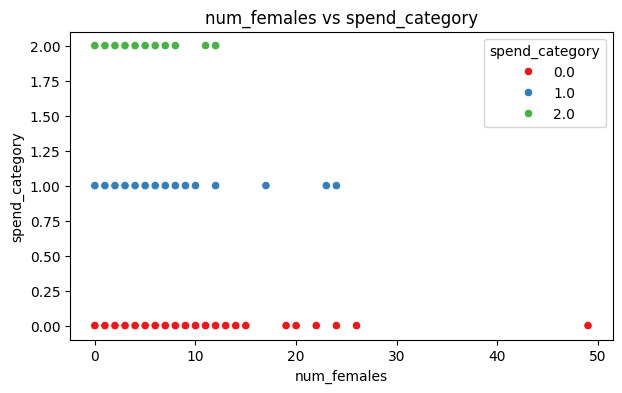

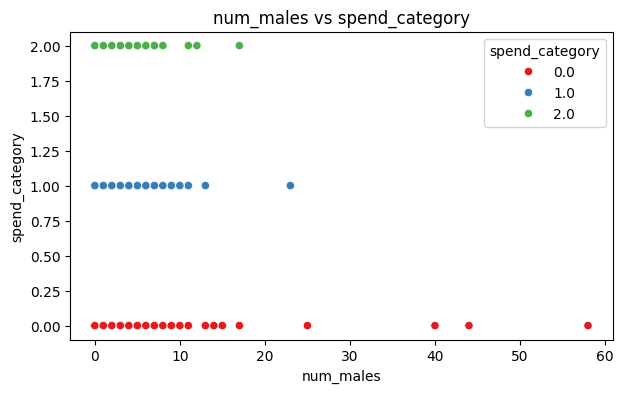

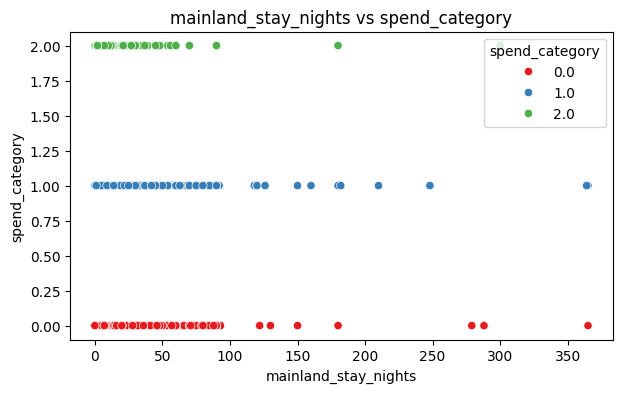

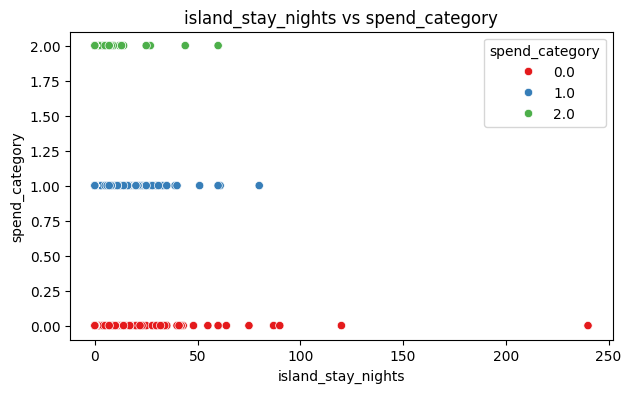

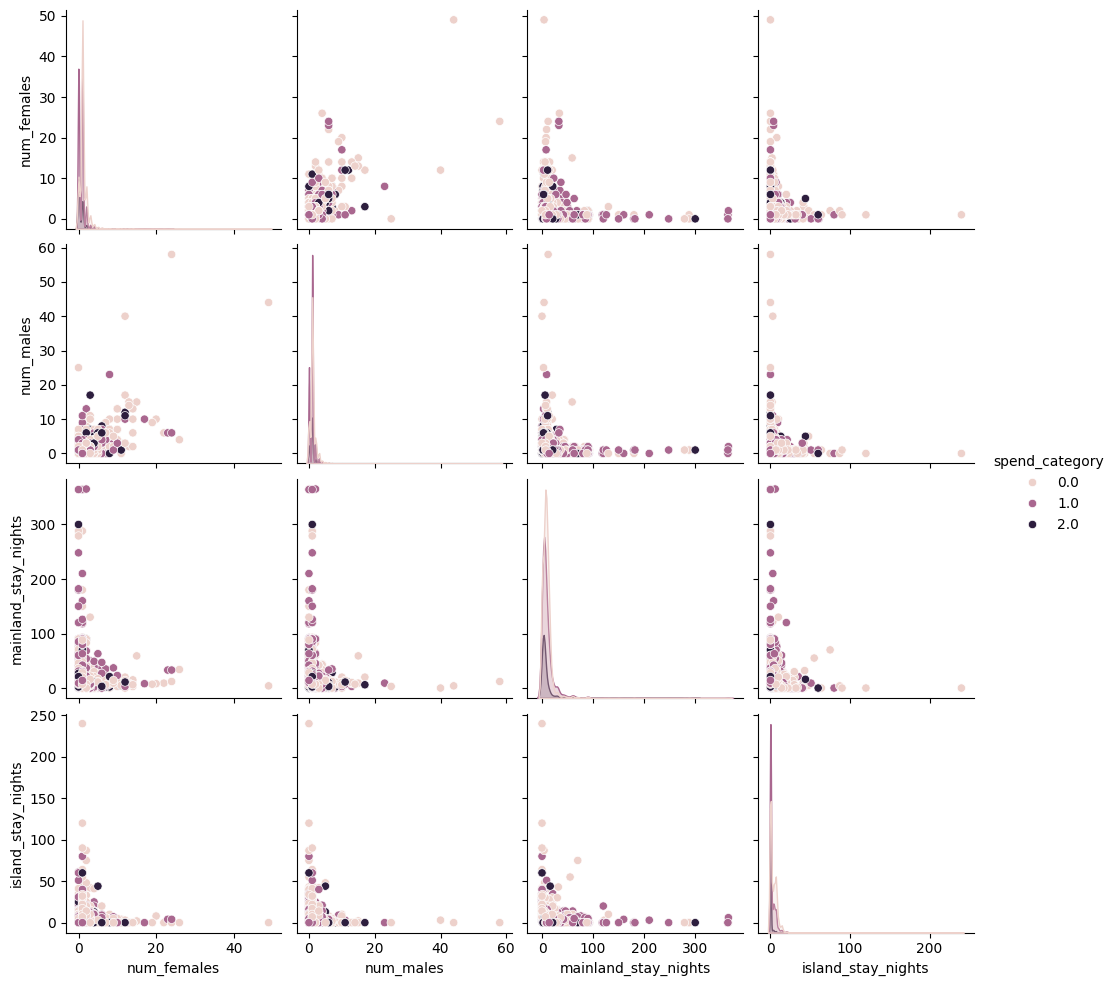


=== CORRELATION MATRIX ===
                      num_females  num_males  mainland_stay_nights  \
num_females              1.000000   0.448119             -0.000070   
num_males                0.448119   1.000000             -0.035149   
mainland_stay_nights    -0.000070  -0.035149              1.000000   
island_stay_nights       0.098306   0.019725             -0.103733   

                      island_stay_nights  
num_females                     0.098306  
num_males                       0.019725  
mainland_stay_nights           -0.103733  
island_stay_nights              1.000000  


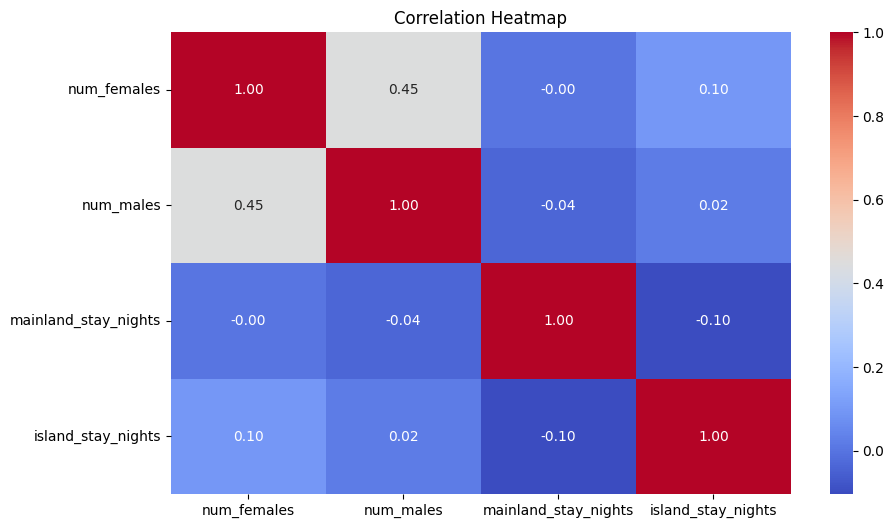


=== COVARIANCE MATRIX ===
                      num_females  num_males  mainland_stay_nights  \
num_females              1.608247   0.698560             -0.001289   
num_males                0.698560   1.524854             -0.631558   
mainland_stay_nights    -0.001289  -0.631558            211.659909   
island_stay_nights       0.639869   0.125023             -7.745450   

                      island_stay_nights  
num_females                     0.639869  
num_males                       0.125023  
mainland_stay_nights           -7.745450  
island_stay_nights             26.340150  


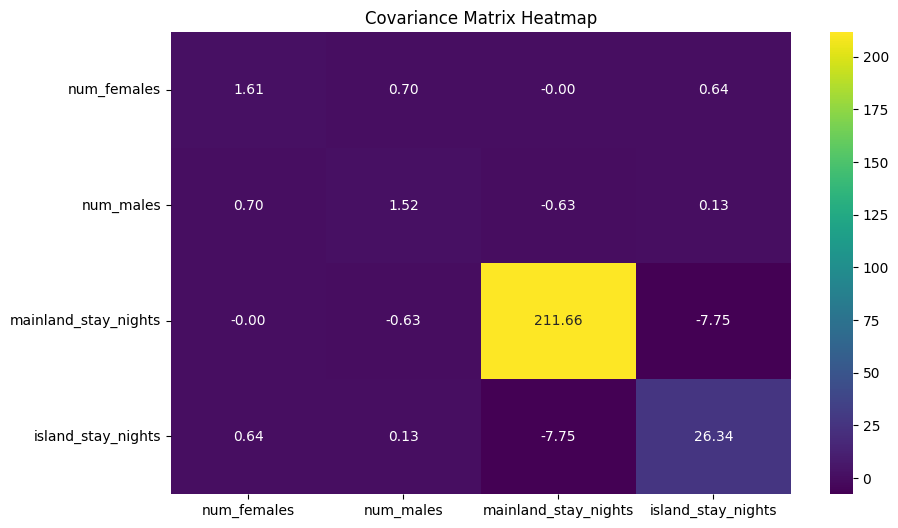

In [22]:
# ============================
#   EDA + OUTLIER ANALYSIS
#   MULTICLASS SPEND CATEGORY
# ============================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------------
# Load Training Data
# ---------------------------------------------------------------------
train_path = "/content/drive/MyDrive/ML_Project/MultinomialClassification/Dataset/train.csv"   # <-- CHANGE PATH
train_df = pd.read_csv(train_path)

print("Train shape:", train_df.shape)
print(train_df.head())

# ---------------------------------------------------------------------
# Target column
# ---------------------------------------------------------------------
TARGET = "spend_category"

# ---------------------------------------------------------------------
# Numeric columns (from dataset description)
# ---------------------------------------------------------------------
numeric_cols = [
    "num_females",
    "num_males",
    "mainland_stay_nights",
    "island_stay_nights",
    # # after cleaning / mapping:
    # "total_trip_days_numeric",
    # "days_booked_before_trip_numeric"
]

print("\nNumeric Columns:", numeric_cols)

# ==========================================================
# 1. Summary Statistics
# ==========================================================
print("\n=== SUMMARY STATISTICS ===")
print(train_df[numeric_cols].describe())

# ==========================================================
# 2. Boxplots → Outlier Detection
# ==========================================================
plt.figure(figsize=(16, 8))
train_df[numeric_cols].boxplot()
plt.title("Boxplots of Numeric Features (Outlier Detection)")
plt.xticks(rotation=45)
plt.show()

# Individual boxplots
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=train_df[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

# ==========================================================
# 3. Scatter Plots vs Target
# ==========================================================
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(
        x=train_df[col],
        y=train_df[TARGET],
        hue=train_df[TARGET],
        palette="Set1"
    )
    plt.title(f"{col} vs {TARGET}")
    plt.show()

# ==========================================================
# 4. Pairplot (numeric + target)
# ==========================================================
sns.pairplot(train_df[numeric_cols + [TARGET]], hue=TARGET)
plt.show()

# ==========================================================
# 5. CORRELATION MATRIX (Pearson)
# ==========================================================
corr_matrix = train_df[numeric_cols].corr()

print("\n=== CORRELATION MATRIX ===")
print(corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# ==========================================================
# 6. COVARIANCE MATRIX (Requested)
# ==========================================================
cov_matrix = train_df[numeric_cols].cov()

print("\n=== COVARIANCE MATRIX ===")
print(cov_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(cov_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title("Covariance Matrix Heatmap")
plt.show()



In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# =====================================================
# STEP 1 — LOAD DATA
# =====================================================

train_path = "/content/drive/MyDrive/ML_Project/MultinomialClassification/Dataset/train.csv"
test_path  = "/content/drive/MyDrive/ML_Project/MultinomialClassification/Dataset/test.csv"



df_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)

TARGET = "spend_category"
ID_COL = "trip_id"

print("Original Training Shape:", df_raw.shape)
print("Original Test Shape:", test_raw.shape)


# =====================================================
# HELPER — Convert Range (15-30, 90+) to numeric
# =====================================================
def range_to_mid(x):
    x = str(x).strip()
    if x.lower() in ["none", "", "nan", "null"]:
        return np.nan
    if "+" in x:
        return float(x.replace("+", ""))
    if "-" in x:
        a, b = x.split("-")
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return np.nan


# =====================================================
# STEP 2 — GLOBAL COLUMN DEFINITIONS
# =====================================================
binary_cols = [
    "is_first_visit","intl_transport_included","accomodation_included",
    "food_included","domestic_transport_included","sightseeing_included",
    "guide_included","insurance_included"
]

categorical_cols = [
    "country","age_group","travel_companions","main_activity",
    "visit_purpose","tour_type","info_source","arrival_weather"
]

numeric_count_cols = ["num_females","num_males","mainland_stay_nights","island_stay_nights"]


# =====================================================
# STEP 3 — REMOVE NULL TARGETS FIRST
# =====================================================
removed_target_nulls = df_raw[TARGET].isnull().sum()
print("Rows removed due to null spend_category:", removed_target_nulls)

df_raw = df_raw[df_raw[TARGET].notnull()].reset_index(drop=True)
print("Training shape after removing null targets:", df_raw.shape)


# =====================================================
# STEP 4 — MAIN PREPROCESSING FUNCTION
# =====================================================
def preprocess_raw_df(df):
    df = df.copy()

    # Clean strings
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.rstrip(',')

    # Binary processing
    for c in binary_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.lower()
            df[c] = df[c].replace({
                "yes": 1,
                "no": 0,
                "nan": np.nan,
                "none": np.nan,
                "null": np.nan,
                "": np.nan
            })
            df[c] = df[c].fillna(0).astype(int)

    # Numeric count fields
    for c in numeric_count_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    # =====================================================
    # SAFE ORDINAL ENCODING FOR RANGE COLUMNS
    # =====================================================

    # Clean weird string values
    def clean_str(x):
        x = str(x).strip().lower()
        if x in ["nan", "none", "null", ""]:
            return np.nan
        return x

    # Clean raw string columns
    if "days_booked_before_trip" in df.columns:
        df["days_booked_before_trip_clean"] = df["days_booked_before_trip"].apply(clean_str)

    if "total_trip_days" in df.columns:
        df["total_trip_days_clean"] = df["total_trip_days"].apply(clean_str)

    # Define ordinal mappings
    ordinal_days_booked = {
        "1-7": 1,
        "8-14": 2,
        "15-30": 3,
        "31-60": 4,
        "61-90": 5,
        "90+": 6
    }

    ordinal_total_trip = {
        "1-6": 1,
        "7-14": 2,
        "15-30": 3,
        "30+": 4
    }

    # Map → Fill Missing → Convert to int
    if "days_booked_before_trip_clean" in df.columns:
        df["days_booked_before_trip_ord"] = (
            df["days_booked_before_trip_clean"]
                .map(ordinal_days_booked)
        )

        # Fill NaN with mode **of ordinal values**
        df["days_booked_before_trip_ord"].fillna(
            df["days_booked_before_trip_ord"].mode()[0],
            inplace=True
        )

        df["days_booked_before_trip_ord"] = df["days_booked_before_trip_ord"].astype(int)

    if "total_trip_days_clean" in df.columns:
        df["total_trip_days_ord"] = (
            df["total_trip_days_clean"]
                .map(ordinal_total_trip)
        )

        # Fill NaN with mode of ordinal values
        df["total_trip_days_ord"].fillna(
            df["total_trip_days_ord"].mode()[0],
            inplace=True
        )

        df["total_trip_days_ord"] = df["total_trip_days_ord"].astype(int)



    # Special requirements → binary
    if "has_special_requirements" in df.columns:
        df["has_special_req_bin"] = df["has_special_requirements"].astype(str).apply(
            lambda x: 0 if x.lower() in ["none", "", "nan"] else 1
        )

    return df


# =====================================================
# APPLY PREPROCESSING TO TRAIN & TEST
# =====================================================
df = preprocess_raw_df(df_raw).reset_index(drop=True)
test_df = preprocess_raw_df(test_raw).reset_index(drop=True)

print("\nAfter Base Preprocessing:")
print(df.shape)


# =====================================================
# STEP 5 — IMPUTATIONS (NO NaNs must remain)
# =====================================================

# Categorical mode fill
for c in categorical_cols:
    if c in df.columns:
        mode = df[c].mode()[0]
        df[c] = df[c].fillna(mode)
        test_df[c] = test_df[c].fillna(mode)

# =========================================================
# OUTLIER REMOVAL (TRAIN ONLY)
# And count number of rows removed per condition
# =========================================================

clean_df = df.copy()
initial_rows = len(clean_df)

outlier_info = {}

# ----- num_females ≤ 10 -----
before = len(clean_df)
clean_df = clean_df[clean_df["num_females"] <= 10]
after = len(clean_df)
outlier_info["num_females"] = before - after

# ----- Rule 1: num_males ≤ 10 -----
before = len(clean_df)
clean_df = clean_df[clean_df["num_males"] <= 10]
after_rule1 = len(clean_df)
removed_rule1 = before - after_rule1
before_rule2 = len(clean_df)

# Save results
outlier_info["num_males_threshold"] = removed_rule1
print("Removed (num_males > 20):", removed_rule1)


# ----- mainland_stay_nights ≤ 100 -----
before = len(clean_df)
clean_df = clean_df[clean_df["mainland_stay_nights"] <= 90]
after = len(clean_df)
outlier_info["mainland_stay_nights"] = before - after

# ----- island_stay_nights ≤ 21 -----
before = len(clean_df)
clean_df = clean_df[clean_df["island_stay_nights"] <= 60]
after = len(clean_df)
outlier_info["island_stay_nights"] = before - after

final_rows = len(clean_df)

# =========================================================
# PRINT OUTLIER REMOVAL SUMMARY
# =========================================================
print("\n========== OUTLIER REMOVAL SUMMARY ==========")
for col, removed in outlier_info.items():
    print(f"{col}: removed {removed} rows")

print("---------------------------------------------")
print(f"Total rows removed: {initial_rows - final_rows}")
print(f"Final Training Shape after Outlier Removal: {clean_df.shape}")
print("Test Shape (unchanged):", test_df.shape)


# =====================================================
# STEP 5 — FINAL FEATURE DEFINITIONS (No NaNs left)
# =====================================================

numeric_features = [
    "num_females",
    "num_males",
    "mainland_stay_nights",
    "island_stay_nights",
    "days_booked_before_trip_ord",
    "total_trip_days_ord"
]

binary_features = binary_cols + ["has_special_req_bin"]

categorical_features = categorical_cols

all_features = numeric_features + binary_features + categorical_features

clean_df = clean_df[all_features + [TARGET]]
test_df_final = test_df[all_features]




Original Training Shape: (12654, 25)
Original Test Shape: (5852, 24)
Rows removed due to null spend_category: 34
Training shape after removing null targets: (12620, 25)


/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] =


After Base Preprocessing:
(12620, 30)
Removed (num_males > 20): 8

========== OUTLIER REMOVAL SUMMARY ==========
num_females: removed 28 rows
num_males_threshold: removed 8 rows
mainland_stay_nights: removed 27 rows
island_stay_nights: removed 8 rows
---------------------------------------------
Total rows removed: 71
Final Training Shape after Outlier Removal: (12549, 30)
Test Shape (unchanged): (5852, 29)


/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-3259718590.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] =

In [24]:
for col in df.columns:
    print("\n====================================")
    print(f"COLUMN: {col}")
    print("====================================")

    print(f"Unique count: {df[col].nunique()}")

    # Sorted unique values
    print("\nSorted unique values:")
    try:
        # Works for numeric OR sortable categories
        print(sorted(df[col].dropna().unique()))
    except:
        # For mixed types like strings + numbers
        print(sorted(df[col].astype(str).unique()))

    # Sorted value counts
    print("\nSorted value counts (by value):")
    try:
        print(df[col].value_counts(dropna=False).sort_index())
    except:
        # If index has mixed types, convert to string
        vc = df[col].astype(str).value_counts(dropna=False)
        vc.index = vc.index.astype(str)
        print(vc.sort_index())

    print("------------------------------------")




COLUMN: trip_id
Unique count: 12620

Sorted unique values:
['tour_id000yfpco', 'tour_id003q62x6', 'tour_id00bp42je', 'tour_id00e73al3', 'tour_id00kt79lk', 'tour_id00kviprn', 'tour_id01234lhk', 'tour_id012bgdi5', 'tour_id018qmbl7', 'tour_id01qoax1x', 'tour_id01tbyi8d', 'tour_id01x4e7r5', 'tour_id01y8ocy6', 'tour_id01znxt4g', 'tour_id023cgz0q', 'tour_id02aikus3', 'tour_id02jptqk3', 'tour_id02ldhvc4', 'tour_id02s6tw0v', 'tour_id02ufouad', 'tour_id02vh4rh8', 'tour_id039dqx5o', 'tour_id03ak2hnm', 'tour_id03alzojb', 'tour_id03aochq1', 'tour_id03edrxkx', 'tour_id03f0zt6u', 'tour_id03fg66s3', 'tour_id03hanq7w', 'tour_id03nwoiew', 'tour_id03rep8c5', 'tour_id03rjhs3x', 'tour_id03tc4n6o', 'tour_id03v1ze5i', 'tour_id041n71hl', 'tour_id04342q6b', 'tour_id044kx1l8', 'tour_id048mewlq', 'tour_id04jrw6ej', 'tour_id04ko8db7', 'tour_id04qyjo59', 'tour_id050zb3dn', 'tour_id052aun3l', 'tour_id052zmb5g', 'tour_id0545vwjg', 'tour_id054ttgrd', 'tour_id059jxwdp', 'tour_id05rg3iog', 'tour_id05wlv9eh', 'tour_id